# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

For white noise, the autocovariance is nearly zero for all lags except when $\tau=0$ (where the autocovariance equals the variance $\sigma^2$). The standard deviation reflects the variability of the autocovariance in the simulations and indicates that changes in autocovariance are only observed at $\tau=0$.

In the case of the periodogram, it exhibits a very flat power spectral density, indicating that the noise has equal power across all frequencies. The standard deviation helps to illustrate the consistent characteristics of power spectral density in the frequency domain.

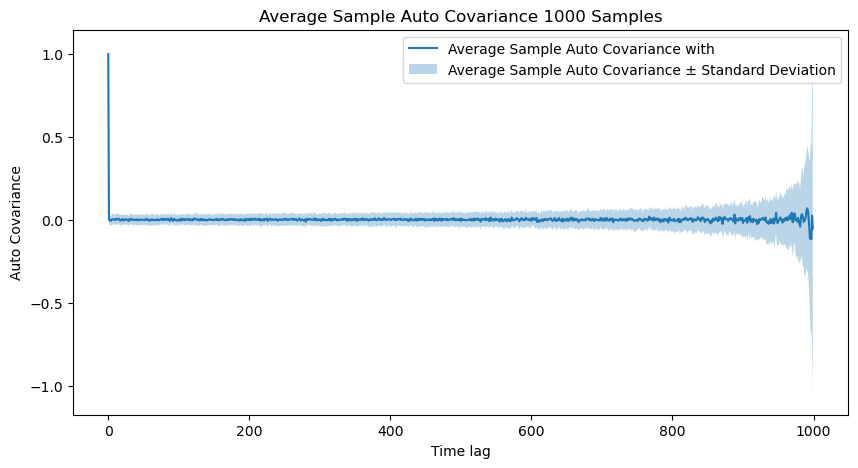

In [45]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
# periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
# freqs = np.linspace(0, 0.5, 200)
# ##


# fig, ax = fig_ax(figsize=(9, 5))

# avg = periodograms.mean(axis=0)
# std = periodograms.std(axis=0)
# ax.plot(freqs, avg, 'k-')
# ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


import numpy as np
import matplotlib.pyplot as plt

N = 1000
num_simulations = 100
sigma_sq = 1.0
fs = 1.0  # sampling frequency

autocovariances = np.zeros((num_simulations, N))

# 100 times iterations
for i in range(num_simulations):
    X = np.random.normal(0, np.sqrt(sigma_sq), N)  # generate gaussian white noise
    for tau in range(N):
        autocovariances[i, tau] = np.mean(X[:N - tau] * X[tau:])



# calculate average and standard deviation
avg_autocov = np.mean(autocovariances, axis=0)
std_autocov = np.std(autocovariances, axis=0)

# plot
plt.figure(figsize=(10, 5))
plt.plot(avg_autocov, label='Average Sample Auto Covariance with ')
plt.fill_between(range(N), avg_autocov - std_autocov, avg_autocov + std_autocov, alpha=0.3, label='Average Sample Auto Covariance ± Standard Deviation')
plt.xlabel('Time lag')
plt.ylabel('Auto Covariance')
plt.legend()
plt.title('Average Sample Auto Covariance '+ str(N) + " Samples")
plt.show()


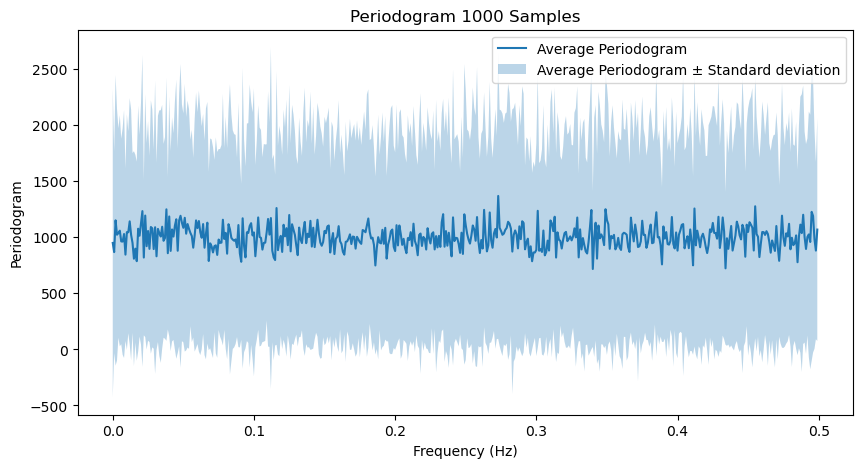

In [4]:
from scipy.fft import fft

periodograms = np.zeros((num_simulations, N))

for i in range(num_simulations):
    X = np.random.normal(0, np.sqrt(sigma_sq), N) 
    F = fft(X)
    periodograms[i] = np.abs(F)**2


# Calculate average periodogram and standard deviation
avg_periodogram = np.mean(periodograms, axis=0)
std_periodogram = np.std(periodograms, axis=0)

# Only take positive frequency
frequencies = np.fft.fftfreq(N, 1/fs)
positive_frequencies = frequencies[:N // 2]
avg_periodogram = avg_periodogram[:N // 2]
std_periodogram = std_periodogram[:N // 2]

# plot
plt.figure(figsize=(10, 5))
plt.plot(positive_frequencies, avg_periodogram, label='Average Periodogram')
plt.fill_between(positive_frequencies, avg_periodogram - std_periodogram, avg_periodogram + std_periodogram, alpha=0.3, label='Average Periodogram ± Standard deviation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Periodogram')
plt.legend()
plt.title('Periodogram '+ str(N) + " Samples")
plt.show()

## Question 9

As seen in the previous question, the problem with the periodogram is the fact that its variance does not decrease with the sample size.
A simple procedure to obtain a consistent estimate is to divide the signal in $K$ sections of equal durations, compute a periodogram on each section and average them.
Provided the sections are independent, this has the effect of dividing the variance by $K$. 
This procedure is known as Bartlett's procedure.

Rerun the experiment of Question~\ref{ex:wn-exp}, but replace the periodogram by Barlett's estimate (set $K=5$). What do you observe.

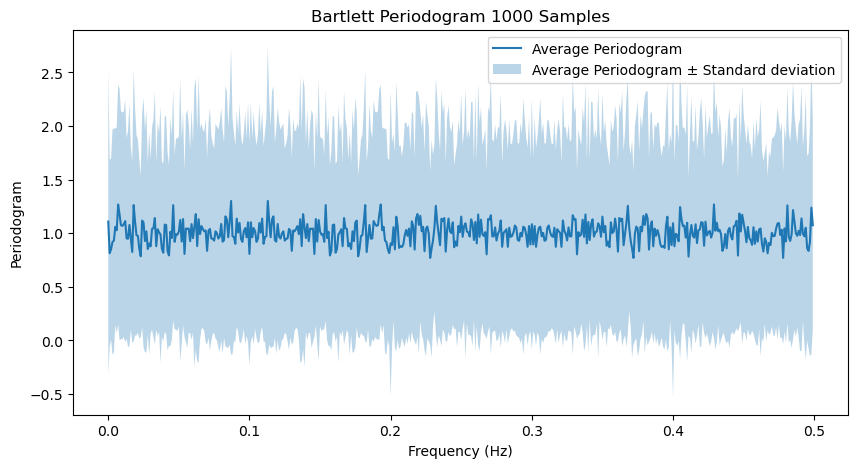

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
N = 1000  # Choose your desired value of N
num_simulations = 100
sigma_sq = 1.0
fs = 1.0  # Sampling frequency
K = 5  # Number of sections for Bartlett's estimate

# Initialize arrays to store results
average_bartlett_periodograms = []

# Create frequency axis
frequencies = np.fft.fftfreq(N, 1/fs)
positive_frequencies = frequencies[:N // 2]

# Perform the experiment for the specified value of N
bartlett_periodograms = np.zeros((num_simulations, N))

for i in range(num_simulations):
    X = np.random.normal(0, np.sqrt(sigma_sq), N)
    section_size = N // K
    section_periodograms = np.zeros((K, N))

    # Divide the signal into K sections and compute the periodogram for each section
    for k in range(K):
        start = k * section_size
        if (k!=K-1):
            end = (k + 1) * section_size
        else:
            end = N
        section = X[start:end]
        section_periodograms[k][start:end]  = np.abs(np.fft.fft(section))**2 / section_size

    # Sum the periodograms from all sections
    bartlett_periodograms[i] = np.sum(section_periodograms, axis=0)

# Average the periodograms from all simulations
average_periodogram = np.mean(bartlett_periodograms, axis=0)[:N // 2]
std_periodogram = np.std(bartlett_periodograms, axis=0)[:N // 2]
average_bartlett_periodograms.append(average_periodogram)

# Plot the results for the specified value of N
plt.figure(figsize=(10, 5))
plt.plot(positive_frequencies, average_periodogram, label='Average Periodogram')
plt.fill_between(positive_frequencies, average_periodogram - std_periodogram, average_periodogram + std_periodogram, alpha=0.3, label='Average Periodogram ± Standard deviation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Periodogram')
plt.legend()
plt.title('Bartlett Periodogram '+ str(N) + " Samples")
plt.show()


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [6]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  
y_train = list()  

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy() 
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  
y_test = list() 

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

Combine the DTW and a k-neighbors classifier to classify each step. Find the optimal number of neighbors with 5-fold cross-validation and report the optimal number of neighbors and the associated F-score. Comment briefly

### Data understanding

168:78
168
88:69
88


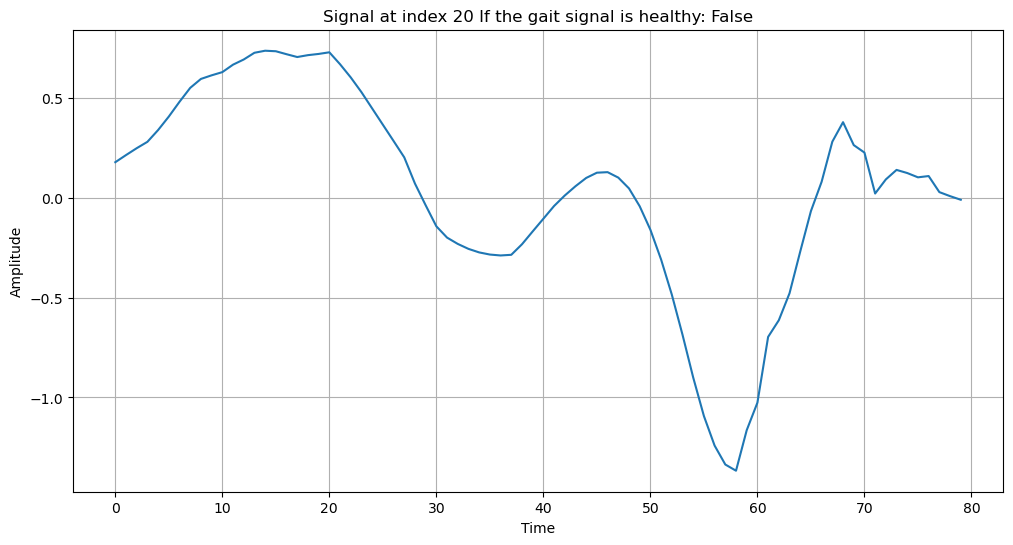

In [47]:
print (str(len(X_train))+":" + str(len(X_train[1])))
print (str(len(y_train)))
print (str(len(X_test))+":" + str(len(X_test[1])))
print (str(len(y_test)))

import matplotlib.pyplot as plt

signal_index = 20
signal_to_plot = X_train[signal_index]
time_axis = range(len(signal_to_plot))

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis, signal_to_plot)
plt.title(f'Signal at index {signal_index} If the gait signal is healthy: {"True" if y_train[signal_index] == 0 else "False"}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### Training with KNN


We used the FastDTW algorithm to compute the DTW distance between x and y and returned this distance.

We created a Stratified K-Fold cross-validator, kf, dividing the data into 5 folds and performing training and validation on each fold.

X_train_padded and X_test_padded are the training and testing sets that have been applied linear interpolation to make their time series lengths consistent.

In the end, we determined that the optimal k value is 1, resulting in an F-score of 0.8878 in the  training set.

But when we test the model in the test set, the F-score decrease into 0.4630 which is not a good score for this user cases.

The following is the code:


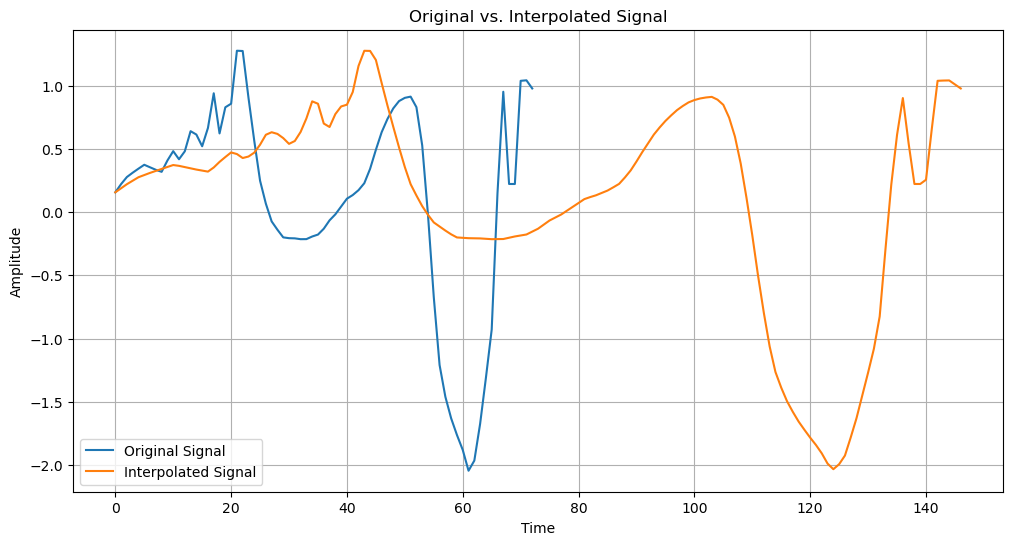

In [48]:
# Test linear interpolation
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def linear_interpolation(signal, new_length):
    interpolator = interp1d(np.arange(len(signal)), signal, kind='linear', fill_value="extrapolate")
    
    new_time_points = np.linspace(0, len(signal) - 1, new_length)
    
    new_signal = interpolator(new_time_points)
    
    return new_signal

max_length_X_train = max(len(signal) for signal in X_train)
max_length_X_test = max(len(signal) for signal in X_test)
max_length = max(max_length_X_train, max_length_X_test)

X_train_padded_int = [linear_interpolation(signal, max_length) for signal in X_train]
X_test_padded_int = [linear_interpolation(signal, max_length) for signal in X_test]

example_signal_index = 2

# Original signal
original_signal = X_train[example_signal_index]

# Interpolated signal
interpolated_signal = X_train_padded_int[example_signal_index]

# Time axes for both signals
time_axis_original = np.arange(len(original_signal))
time_axis_interpolated = np.arange(len(interpolated_signal))

# Create a single plot for comparison
plt.figure(figsize=(12, 6))

plt.plot(time_axis_original, original_signal, label='Original Signal')
plt.plot(time_axis_interpolated, interpolated_signal, label='Interpolated Signal')

plt.title('Original vs. Interpolated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.show()

In [50]:
# Training and find the best score
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

def dtw(x, y):
    distance, path = fastdtw(x, y)
    return distance

f_scores = []
k_values = [1, 3, 5, 7, 9]

# linear_interpolation
max_length_X_train = max(len(signal) for signal in X_train)
max_length_X_test = max(len(signal) for signal in X_test)
max_length = max(max_length_X_train, max_length_X_test)

X_train_padded = [linear_interpolation(signal, max_length) for signal in X_train]
X_test_padded = [linear_interpolation(signal, max_length) for signal in X_test]

knn_classifiers = []

# Create K-Fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True)

f_scores_fold = []  # Store F-scores for each fold

for k in k_values:
    print(f"Testing k = {k}")

    for train_index, test_index in kf.split(X_train_padded, y_train):
        X_train_fold, X_val_fold = [X_train_padded[i] for i in train_index], [X_train_padded[i] for i in test_index]
        y_train_fold, y_val_fold = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

        # Initialize K-Neighbors Classifier
        knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=dtw)
        knn_classifier.fit(X_train_fold, y_train_fold)
        knn_classifiers.append(knn_classifier)
        # Predict on the validation set
        y_val_pred = knn_classifier.predict(X_val_fold)

        f_score = f1_score(y_val_fold, y_val_pred)
        f_scores_fold.append(f_score)

    # Calculate the average F-score across all folds for the current k value
    avg_f_score = np.mean(f_scores_fold)
    f_scores.append(avg_f_score)


Testing k = 1
Testing k = 3
Testing k = 5
Testing k = 7
Testing k = 9


In [51]:
# Find the k value that yields the highest F-score
optimal_k = k_values[np.argmax(f_scores)]
max_f_score = max(f_scores)
optimal_k_index = k_values.index(optimal_k) 

# Predict on the test set
y_test_pred = knn_classifiers[optimal_k_index].predict(X_test_padded)
# Calculate the F1 score for the test set
f1_test = f1_score(y_test, y_test_pred)

print(f'F1 Score on Test Set: {f1_test:.4f}')
print(f'Optimal number(k): {optimal_k}')
print(f'F-score: {max_f_score:.4f}')

F1 Score on Test Set: 0.4630
Optimal number(k): 1
F-score: 0.8878


## Question 11

Display on Figure a badly classified step from each class (healthy/non-healthy).

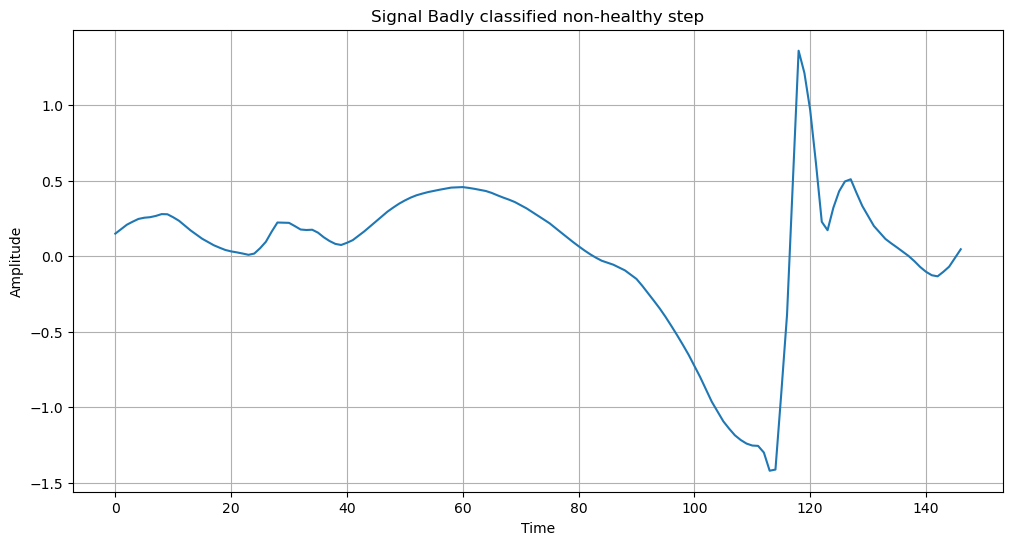

In [35]:
# Signal Badly classified non-healthy step one image
result_1 = []
for i in range(len(y_test_pred)):
    if y_test[i] == 0 and y_test_pred[i] == 1:
        result_1.append(i)
index_Badly_Classified_non_healthy = result_1[0]

# Plot the signal
time_axis = range(len(X_test_padded[index_Badly_Classified_non_healthy]))
plt.figure(figsize=(12, 6))
plt.plot(time_axis, X_test_padded[index_Badly_Classified_non_healthy])
plt.title(f'Signal Badly classified non-healthy step')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

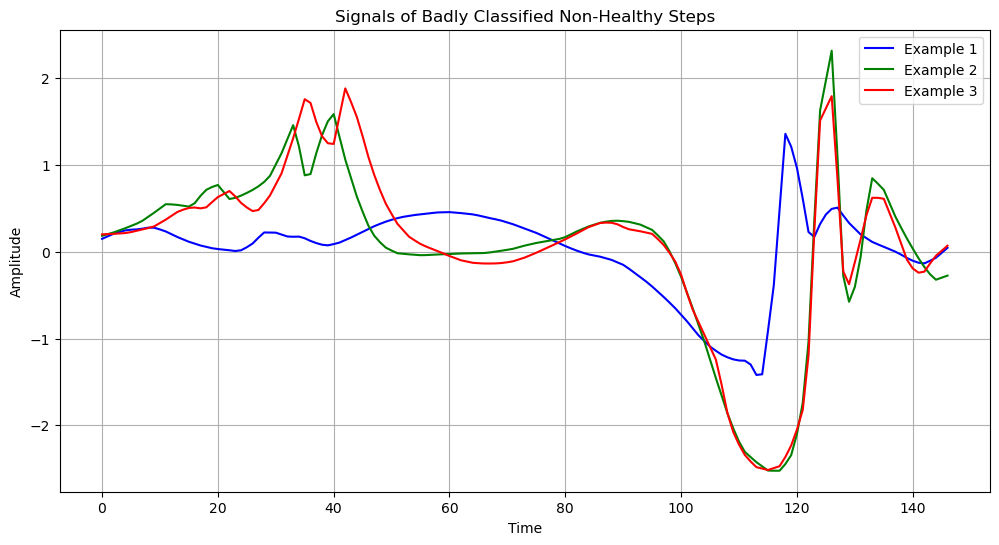

In [38]:
# Signal Badly classified non-healthy step three images
result_1 = []
count = 0  # Counter for the number of images to plot

# Find and plot the first three badly classified non-healthy steps
for i in range(len(y_test_pred)):
    if y_test[i] == 0 and y_test_pred[i] == 1:
        result_1.append(i)
        count += 1

    if count == 3:  # Stop after finding three examples
        break

# Create a single plot for the three signals
plt.figure(figsize=(12, 6))

colors = ['b', 'g', 'r']  # Specify colors for the three examples

for idx, index_Badly_Classified_non_healthy in enumerate(result_1):
    time_axis = range(len(X_test_padded[index_Badly_Classified_non_healthy]))
    
    plt.plot(time_axis, X_test_padded[index_Badly_Classified_non_healthy], label=f'Example {idx + 1}', color=colors[idx])

plt.title('Signals of Badly Classified Non-Healthy Steps')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


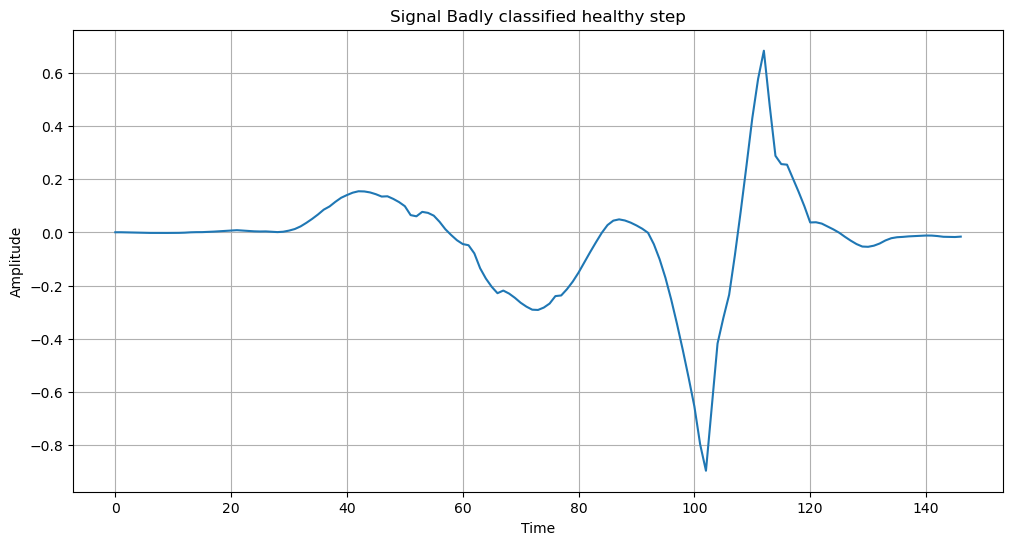

In [54]:
# Signal Badly classified healthy step
result_1 = []
for i in range(len(y_test_pred)):
    if y_test[i] == 1 and y_test_pred[i] == 0:
        result_1.append(i)
index_Badly_Classified_non_healthy = result_1[0]

# Plot the signal
time_axis = range(len(X_test_padded[index_Badly_Classified_non_healthy]))
plt.figure(figsize=(12, 6))
plt.plot(time_axis, X_test_padded[index_Badly_Classified_non_healthy])
plt.title(f'Signal Badly classified healthy step')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

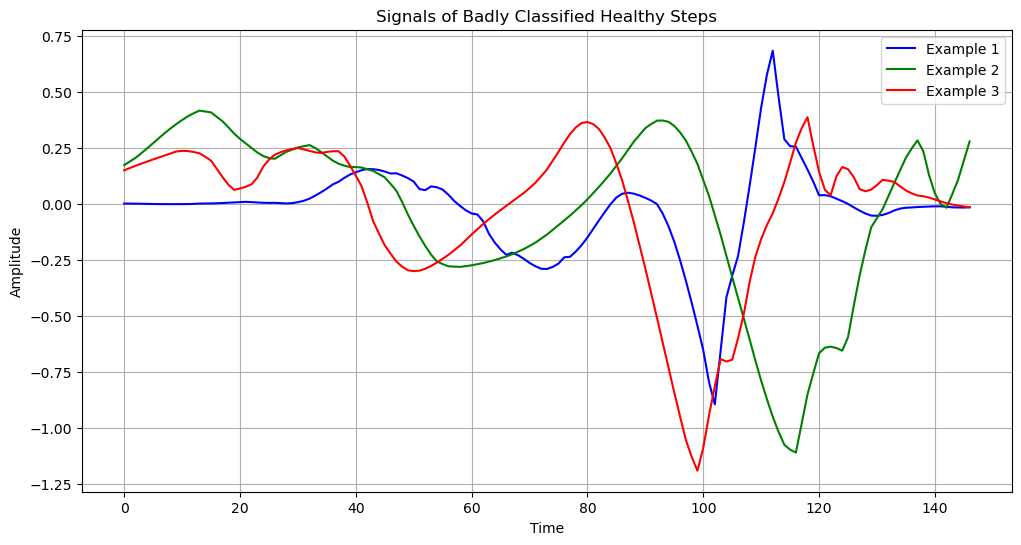

In [41]:
# Signal Badly classified non-healthy step three images
result_1 = []
count = 0  # Counter for the number of images to plot

# Find and plot the first three badly classified non-healthy steps
for i in range(len(y_test_pred)):
    if y_test[i] == 1 and y_test_pred[i] == 0:
        result_1.append(i)
        count += 1

    if count == 3:  # Stop after finding three examples
        break

# Create a single plot for the three signals
plt.figure(figsize=(12, 6))

colors = ['b', 'g', 'r']  # Specify colors for the three examples

for idx, index_Badly_Classified_non_healthy in enumerate(result_1):
    time_axis = range(len(X_test_padded[index_Badly_Classified_non_healthy]))
    
    plt.plot(time_axis, X_test_padded[index_Badly_Classified_non_healthy], label=f'Example {idx + 1}', color=colors[idx])

plt.title('Signals of Badly Classified Healthy Steps')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()
